# Organic matter decomposition kinetics in cranberry agroecosystems 

*Wilfried Dossou-Yovo, Serge Étienne Parent,Noura Ziadi, Élizabeth Parent and Léon Étienne Parent*

In [1]:
print(Sys.Date())

[1] "2020-09-01"


## 1. Objective

This notebook generates the results included in the manuscript *Tea bag index (TBI) and decomposition kinetics in cranberry agroecosystems*. The data set from 2017 trial is a collection of incubated tea bag weight, nitrogen, carbon and sulfur content, nitrogen type and doses on trials fieds. The aims of this study were to measure the TBI and kinetics of plant residue decomposition to estimate soil sequestration capacity in cranberry stands of Eastern Canada.

## 2. Statistical questions

In addition to data exploration, this notebook will answer the following statistical questions.

1. What's affecting 1st order kinetics?
2. What affecting TBI parameters (k)?
3. Where cranberry soils are placed among the axes of the *TBI*?
4. What is the fractal kinetics of litter matterials ?
5. What is the fractal kinetics of litter biochemical composition ?

## 3. Packages and Function

### 3.1 Packages

We need package [tidyverse](https://www.tidyverse.org/) which loads a set of packages for easy data manipulation (e.g. [dplyr](https://www.rdocumentation.org/packages/dplyr/versions/0.7.8)) and visualization (e.g. [ggplot2](https://www.rdocumentation.org/packages/ggplot2/versions/3.2.1)). A set of other packages is used: [nlme](https://www.rdocumentation.org/packages/nlme/versions/3.1-143/topics/nlme) for fitting nonlinear mixed-effects models, the broom package summarises model outputs in a "tidy" way, [e1071](https://www.rdocumentation.org/packages/e1071/versions/1.7-3) to test distributions, [ggmap](https://www.rdocumentation.org/packages/ggmap/versions/3.0.0) for mapping, [ggrepel](https://www.rdocumentation.org/packages/ggrepel/versions/0.8.1) to avoid text overlaping on ggplot2, [patchwork](https://www.rdocumentation.org/packages/patchwork/versions/1.0.0/topics/patchwork-package) to assemble plots in grids, [composition](https://www.rdocumentation.org/packages/compositions/versions/1.40-5) for compositional data transformations.

In [2]:
library("tidyverse")
library("nlme")
library("broom")
library("e1071")
library("ggmap")
library("ggrepel")
library("compositions")
library("patchwork")

Warning message:
"package 'tidyverse' was built under R version 3.6.2"-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.2.1     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
Warning message:
"package 'ggplot2' was built under R version 3.6.2"Warning message:
"package 'tibble' was built under R version 3.6.2"Warning message:
"package 'tidyr' was built under R version 3.6.2"Warning message:
"package 'readr' was built under R version 3.6.2"Warning message:
"package 'purrr' was built under R version 3.6.2"Warning message:
"package 'dplyr' was built under R version 3.6.2"Warning message:
"package 'stringr' was built under R version 3.6.2"Warning message:
"package 'forcats' was built under R version 3.6.2"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning mess

## 3.2 Some custom functions.
### Pseudo R-square
Pseudo R-square allows to measure how well variables of our model explain organic matter decomposition

In [3]:
pseudoR2 <- function(y, y_hat) {
  1 - (sum((y - y_hat)^2) / sum((y - mean(y))^2))
}

# Residuals
residues <- function(model, level = 0, computeResidues = TRUE, residues,
                   main = "") {
  if (computeResidues) {
    r = residuals(model, type="normalized", level)
  } else {
    r = residues
  }
  hist(r, freq=F, main = main, breaks=20)
  xfit<-seq(min(r),max(r),length=40)
  yfit<-dnorm(xfit)
  lines(xfit, yfit, col="red", lwd=2)
  print("Shapiro-Wilk:")
  print(shapiro.test(r))
  print(paste("Kurtosis:", kurtosis(r)))
  print(paste("Skewness:", skewness(r)))
}


## 4. Import data
Here, we load our data `data.csv` available for the project in the `data` folder.

In [4]:
df <- read_csv("data/data.csv")

Parsed with column specification:
cols(
  No = col_double(),
  `Tea type abbr` = col_character(),
  `Tea type` = col_character(),
  `Initial tea weight (g)` = col_double(),
  `Initial total weight (g)` = col_double(),
  `Initial bag weight (g)` = col_double(),
  `Remaining tea weight (g)` = col_double(),
  Farm = col_character(),
  Site = col_character(),
  `Farming system` = col_character(),
  `Nitrogen type` = col_character(),
  `Nitrogen dose` = col_double(),
  Repetition = col_double(),
  `Remaining C (%)` = col_double(),
  `Remaining N (%)` = col_double(),
  `Remaining S (%)` = col_double(),
  `Initial C fraction` = col_double()
)


We create a label `Dose repetition` to create unique identifiers for blocks.

In [5]:
df$`Dose repetition` <- paste0(df$`Nitrogen dose`, '_', df$Repetition,'_', df$Site)

*Cranberry litter* category will be used for the reference category in modeling.

In [6]:
df$`Tea type` <- relevel(factor(df$`Tea type`), ref = 'Cranberry litter')

## 5. Mapping experimental sites

We design a map of our four experimental sites with geographical position collected from Stamen maps. Warnings appear, but it seems its a bug that comes out when mixing ggmap and geom_label_repel.

In [7]:
# table including sites and their geograhic position
sites <- tibble(names = c("Fortier/45", "Fortier/9", "Belanger/A9", "Belanger/10"),
                lat = c(46.2759555, 46.2759555, 46.2329064, 46.3277404),
                lon = c(-71.8584291, -71.8584291, -72.0461854, -71.7486645))

# create two frames, one for zoom out, the other for zoom in
frame_map_zoom_out <- c(left = -90, bottom = 44, right = -53, top = 63)
frame_map_zoom_in <- c(left = -73, bottom = 46, right = -70.5, top = 47)

# to draw the zoom in frame on the zoom out map
rect_zoom <- data.frame(t(data.frame(frame_map_zoom_in)))

# the map with zoom out
map_out <- get_stamenmap(frame_map_zoom_out, zoom = 4, maptype = "toner-lite") %>%
  ggmap() +
  geom_rect(data = rect_zoom, aes(xmin = left, xmax = right,
                                  ymin = bottom, ymax = top,
                                  x = NULL, y = NULL),
            fill = rgb(0, 0, 0, 0.2), colour = "black") +
  #geom_label_repel(data = sites, aes(x = lon, y = lat, label = names)) +
  labs(x = "Longitude", y = "Latiude", title = "A")

# the map with zoom in
map_in <- get_stamenmap(frame_map_zoom_in, zoom = 8, maptype = "toner-lite") %>%
  ggmap() +
  geom_label_repel(data = sites, aes(x = lon, y = lat, label = names)) +
  labs(x = "Longitude", y = "Latiude", title = "B")

# combining the plots
maps_ <- map_out + map_in

ggsave("figures/site_map.png", plot = maps_, width = 8, height = 6, dpi = 600)

Source : http://tile.stamen.com/toner-lite/4/4/4.png
Source : http://tile.stamen.com/toner-lite/4/5/4.png
Source : http://tile.stamen.com/toner-lite/4/4/5.png
Source : http://tile.stamen.com/toner-lite/4/5/5.png
Source : http://tile.stamen.com/toner-lite/8/76/90.png
Source : http://tile.stamen.com/toner-lite/8/77/90.png
Source : http://tile.stamen.com/toner-lite/8/76/91.png
Source : http://tile.stamen.com/toner-lite/8/77/91.png
Warning message in min(x):
"aucun argument trouvé pour min ; Inf est renvoyé"Warning message in max(x):
"aucun argument pour max ; -Inf est renvoyé"Warning message in min(x):
"aucun argument trouvé pour min ; Inf est renvoyé"Warning message in max(x):
"aucun argument pour max ; -Inf est renvoyé"

## 6. Monthly weather data (2008-2018) at Lemieux, Quebec (46° 09′ 56″ N 72° 19′ 28″ W), for experimental sites (Gouvernement du Canada, 2018)

### 6.1 Import data weather

`Data weather` has been collected from environnement canada. The content is the collection of data history about temperature and precipitation from years of field trial (2017 and 2018) and 10 years average (2008 to 2018).

In [8]:
df_weather <- read_csv2("data/data_weather.csv")

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.
Parsed with column specification:
cols(
  Years = col_character(),
  Months = col_character(),
  `Precipitations(mm)` = col_double(),
  `Temperatures(oC)` = col_double()
)


### 6.2 Plot of data weather

In [9]:
df_weather$Months <- factor(df_weather$Months,levels = c("June", "July", "August", "September")) #  Sorting bars by Months

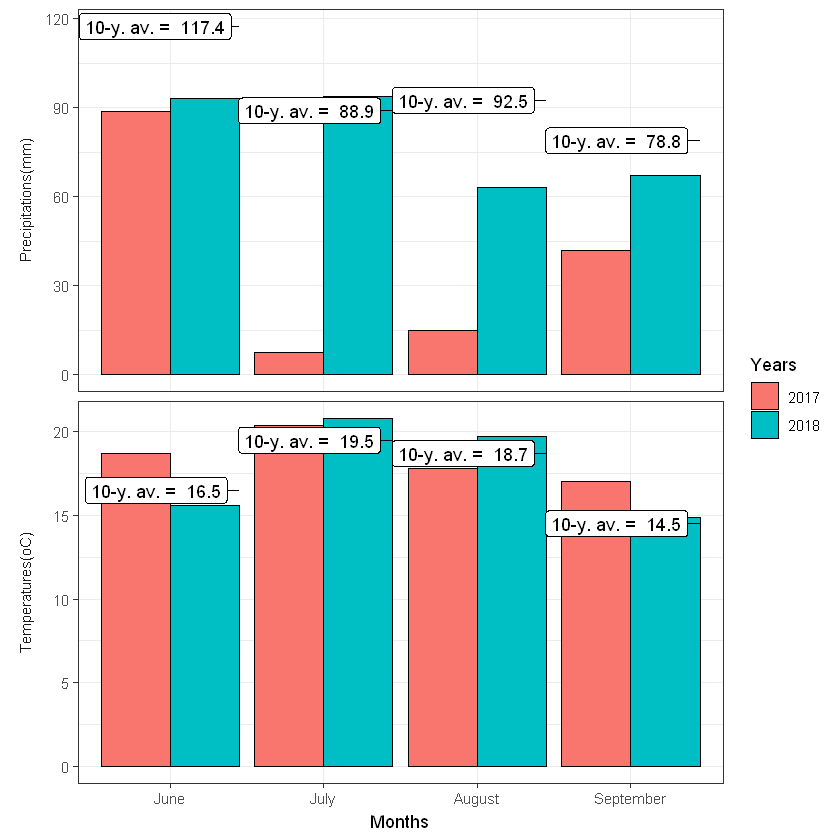

In [10]:
df_weather_long <- df_weather %>%
  pivot_longer(cols = -c(Years, Months))

Weather <- df_weather_long %>%
  filter(Years %in% c("2017", "2018")) %>%
  ggplot(aes(x = `Months`, y = value)) +
  facet_grid(name ~ ., scales = "free", switch = "y") +
  geom_bar(aes(fill= Years), colour = "black", stat="identity", position="dodge") +
  geom_errorbar(data = df_weather_long %>% filter(Years == "10 Years average"),
                mapping = aes(x = `Months`, ymax = value, ymin = value)) +
  geom_label(data = df_weather_long %>% filter(Years == "10 Years average"),
            mapping = aes(label = paste("10-y. av. = ", value), hjust = 0.6, vjust = 0.5)) +
  #scale_fill_brewer(palette = "Set2") +
  theme_bw() +
  theme(axis.title.y = element_blank(),
        strip.background = element_rect(fill = "transparent", colour = "transparent"),
        strip.placement = "outside")
Weather
ggsave("figures/Weather.png", plot = Weather, width = 7, height = 8, dpi = 120)

## 7. Compute the 1st order kinetics

Weight loss rate has been estimated with the function

$k_1 = \frac{-ln \left( \frac{M(t)}{M_0} \right) }{t}$,

where $M_0$ is initial litter organic mass, $M(t)$ is litter organic mass that remains after incubation time $t = 90~days$, and $k_1$ is decomposition rate. 

In [11]:
kinetics_1st <- function(rw, iw, t) {
    -log(rw/iw)/t
}

We can compute `k1` for each row of the `df` table.

In [12]:
df$k1 <- kinetics_1st(rw = df$`Remaining tea weight (g)`,
                      iw = df$`Initial tea weight (g)`,
                      t = 90)

## 8. Data exploration

Boxplot of $k_1$ for different N dosages per litter.

Warning message:
"Removed 49 rows containing non-finite values (stat_boxplot)."

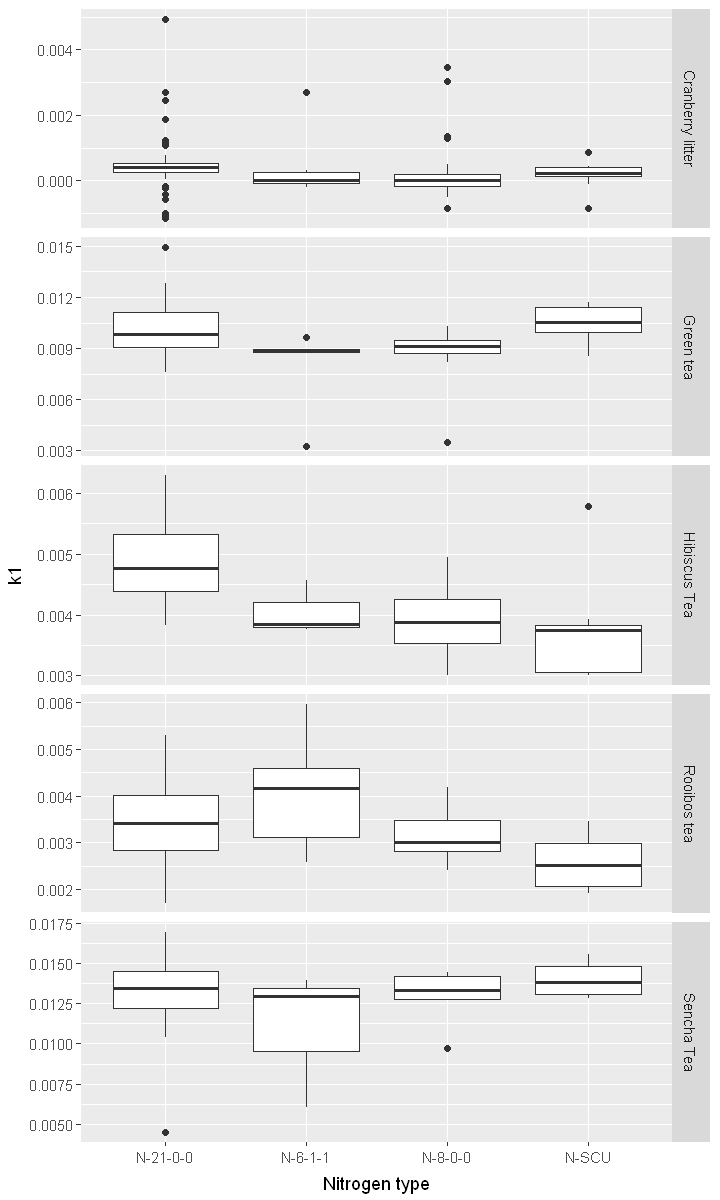

In [13]:
options(repr.plot.width = 6, repr.plot.height = 10)
ggplot(data = df,
       mapping = aes(x = `Nitrogen type`, y = k1)) +
  facet_grid(`Tea type` ~ ., scales = "free") +
  geom_boxplot()

## 9. Mixed model

## 9.1 **Question 1**: What's affecting 1st order kinetics?

The dose is standardized to zero mean and unit variance.

In [14]:
df <- df %>%
  mutate(`Nitrogen dose scaled` = scale(`Nitrogen dose`))

We rename variables without special characters to avoid errors, make sure litters and N dose types are categories, remove NAs in the table and remove categories that might still be in the description but now removed from the table, just in case.

In [15]:
df_mm <- df %>%
  rename(tea = `Tea type`,
         Ntype = `Nitrogen type`,
         Ndose = `Nitrogen dose scaled`) %>%
  mutate(tea = factor(tea),
         Ntype = factor(Ntype)) %>%
  drop_na() %>%
  droplevels()

The model investigates the effect of the type of the dose (`Ntype`), the magnitude of the dose (`Ndose`) and the litter (`tea`) on `k1`, considering the random effect of sites (`Site`) nested in farms (`Farm`).

In [16]:
k1_mm <- lme(fixed = k1 ~ Ntype + Ndose * tea,
                     random = ~ 1 | Farm/Site,
                     data = df_mm)
intervals(k1_mm, level = 0.95)

Approximate 95% confidence intervals

 Fixed effects:
                              lower          est.         upper
(Intercept)           -9.462499e-04  1.239422e-04  1.194134e-03
NtypeN-6-1-1          -3.665047e-04  3.700764e-04  1.106658e-03
NtypeN-8-0-0          -1.743339e-04  6.346989e-04  1.443732e-03
NtypeN-SCU            -3.796524e-04  4.694389e-05  4.735401e-04
Ndose                 -4.208384e-05  1.652003e-04  3.724843e-04
teaGreen tea           9.339279e-03  9.623519e-03  9.907758e-03
teaHibiscus Tea        2.407132e-03  3.666307e-03  4.925482e-03
teaRooibos tea         2.814486e-03  3.098231e-03  3.381976e-03
teaSencha Tea          1.174453e-02  1.300483e-02  1.426513e-02
Ndose:teaGreen tea    -5.759244e-04 -2.997410e-04 -2.355757e-05
Ndose:teaHibiscus Tea -1.100256e-03  2.016238e-04  1.503503e-03
Ndose:teaRooibos tea  -4.628685e-04 -1.901865e-04  8.249546e-05
Ndose:teaSencha Tea   -2.914566e-03 -1.612294e-03 -3.100234e-04
attr(,"label")
[1] "Fixed effects:"

 Random Effec

### 9.2.1 P-value

In [17]:
anova(k1_mm)

,numDF,denDF,F-value,p-value
(Intercept),1,346,90.4235185,0.000000e+00
Ntype,3,346,9.2425070,6.769315e-06
Ndose,1,346,0.4951898,4.820946e-01
tea,4,346,1309.7307309,0.000000e+00
Ndose:tea,4,346,2.4427939,4.649410e-02


### 9.1.2 Pseudo r-square
Pseudo r-square was high with(0.94) and without(0.91) random effect indicated the influence of random effects was not impotant. Moreover, pseudo r-square was high, indicated mixed model was well fit to data.   

In [18]:
pseudoR2(y = df_mm$k1,
         y_hat = predict(k1_mm, level = 0))

pseudoR2(y = df_mm$k1,
         y_hat = predict(k1_mm, level = 2))

[1] 0.9179982

[1] 0.9405054

### 9.1.3 Shapiro-Wilk normality test

[1] "Shapiro-Wilk:"

	Shapiro-Wilk normality test

data:  r
W = 0.93463, p-value = 1.636e-11

[1] "Kurtosis: 4.72506311595992"
[1] "Skewness: 0.0203648806888307"


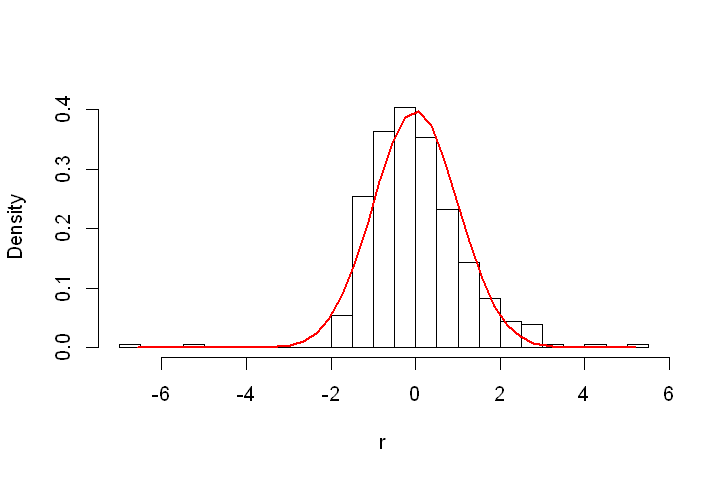

In [19]:
options(repr.plot.width = 6, repr.plot.height = 4)
residues(k1_mm)

### 9.1.4 Reporting the results of the mixed models

I create a table including the results I need: estimates, confidence intervals and p-values.

In [20]:
k1_gg <- data.frame(intervals(k1_mm, which = "fixed")$fixed)
k1_gg <- k1_gg %>%
  mutate(variable = rownames(k1_gg))
k1_gg <- k1_gg %>%
  mutate(pvalue = summary(k1_mm)$tTable[, 5],
         is_significant = ifelse(pvalue <= 0.05, 'Significant at 0.05 level', 'Not significant at 0.05 level'))

k1_gg$variable <- c("Intercept", "N 6-1-1", "N 8-0-0", "N SCU-39-0-0", # Ajust names
                    "Dose N (scaled)", "Green tea", "Hibiscus tea", "Rooibos tea", "Sencha tea",
                     "Green tea : Dose N", "Hibiscus tea : Dose N", "Rooibos tea : Dose N", "Sencha tea : Dose N")

> SÉP. Attention aux p-values. Elles peuvent être trompeuses. En tout cas, le seuil 0.05, lui, risque fort de mener à de fausses conclusions. Voir https://www.nature.com/articles/d41586-019-00857-9 et https://www.tandfonline.com/doi/full/10.1080/00031305.2016.1154108

Adding random effects to the table.

In [21]:
k1_re <- data.frame(matrix(ncol = ncol(k1_gg), nrow = 6))
names(k1_re) <- names(k1_gg)
k1_re$est. <- c(ranef(k1_mm)$Farm[, 1], ranef(k1_mm)$Site[, 1])
k1_re$variable <- c(rownames(ranef(k1_mm)$Farm),
                    rownames(ranef(k1_mm)$Site))

if (!("Belanger" %in% k1_gg$variable)) k1_gg <- bind_rows(k1_gg, k1_re) # with an if to make sure ranefs are stacked only once

Create a facet column to separate effects by effect category in the plot.

In [22]:
k1_gg$facet <- factor(c('Intercept',
                        'N source', 'N source', 'N source',
                        "N dosage",
                        'Tea type', 'Tea type', 'Tea type', 'Tea type',
                        'Tea type × N dosage', 'Tea type × N dosage', 
                        'Tea type × N dosage', 'Tea type × N dosage',
                        "Random effect", "Random effect", "Random effect", "Random effect", "Random effect", "Random effect"))

k1_gg <- k1_gg %>%
  mutate(facet = factor(facet, levels = rev(c("Random effect", "Tea type × N dosage", "Tea type", "N dosage", "N source"))))

The `k1_gg` table is now set up pour the plot.

In [23]:
head(k1_gg)

lower,est.,upper,variable,pvalue,is_significant,facet
-9.462499e-04,1.239422e-04,0.0011941343,Intercept,8.199471e-01,Not significant at 0.05 level,NA
-3.665047e-04,3.700764e-04,0.0011066576,N 6-1-1,3.237498e-01,Not significant at 0.05 level,N source
-1.743339e-04,6.346989e-04,0.0014437317,N 8-0-0,1.237400e-01,Not significant at 0.05 level,N source
-3.796524e-04,4.694389e-05,0.0004735401,N SCU-39-0-0,8.287745e-01,Not significant at 0.05 level,N source
-4.208384e-05,1.652003e-04,0.0003724843,Dose N (scaled),1.179060e-01,Not significant at 0.05 level,N dosage
9.339279e-03,9.623519e-03,0.0099077584,Green tea,2.294584e-199,Significant at 0.05 level,Tea type


Warning message:
"Removed 6 rows containing missing values (geom_segment)."Warning message:
"Removed 6 rows containing missing values (geom_segment)."

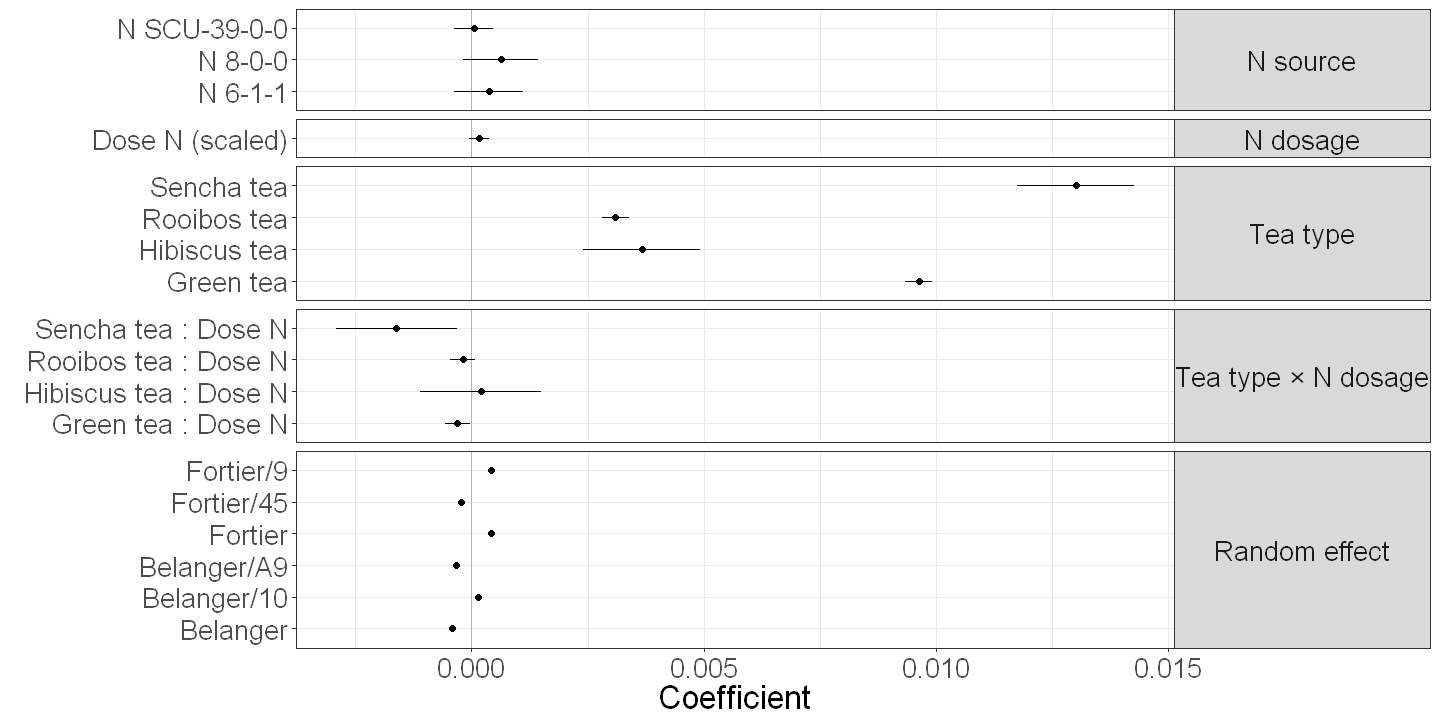

In [24]:
options(repr.plot.width = 12, repr.plot.height = 6)
k1_gg %>%
  filter(variable != "Intercept") %>%
  ggplot(aes(x = est., y = variable)) +
  facet_grid(facet ~ ., scales = 'free', space = 'free') +
  geom_vline(xintercept = 0, colour='grey70') +
  geom_point() +
  geom_segment(aes(x = lower, xend = upper, y = variable, yend = variable)) +
  xlab('Coefficient') +
  ylab('') +
  theme_bw() +
  theme(strip.text.y = element_text(angle=0),
        legend.title = element_blank(),
        legend.position = "bottom",
        text = element_text(size = 20)) +
  ggsave("figures/mixed-model-coefficients.png", width = 8, height = 6, dpi = 600)

How did $k_1$ react across tea types and nitrogen sources for a range of doses, according to the model? To answer this question, I create a grid of values and categories, predict the model for each row of the grid, then put nitrogen dosage back to its original scale.

In [25]:
pred_grid <- expand.grid(tea = unique(df_mm$tea),
                         Ndose = c(min(df_mm$Ndose), max(df_mm$Ndose)),
                         Ntype = unique(df_mm$Ntype))
pred_grid <- pred_grid %>%
  mutate(k1 = predict(k1_mm, newdata = pred_grid,
                              level = 0),
         Ndose = Ndose * sd(df$`Nitrogen dose`) + mean(df$`Nitrogen dose`)) %>%
  rename(`Tea type` = tea,
         `Nitrogen dose` = Ndose,
         `Nitrogen type` = Ntype)

In [26]:
pred_grid %>% sample_n(10)

Tea type,Nitrogen dose,Nitrogen type,k1
Rooibos tea,6.000000e+01,N-8-0-0,0.0038233233
Green tea,3.552714e-15,N-21-0-0,0.0099535922
Green tea,6.000000e+01,N-SCU,0.0096137584
Sencha Tea,3.552714e-15,N-8-0-0,0.0159805809
Cranberry litter,6.000000e+01,N-21-0-0,0.0003457545
Hibiscus Tea,6.000000e+01,N-21-0-0,0.0042827791
Hibiscus Tea,6.000000e+01,N-8-0-0,0.0049174780
Rooibos tea,3.552714e-15,N-SCU,0.0033073989
Rooibos tea,3.552714e-15,N-21-0-0,0.0032604550
Sencha Tea,3.552714e-15,N-6-1-1,0.0157159584


This table allows to plot the model and data superimposed.

Warning message:
"Removed 49 rows containing missing values (geom_point)."Warning message:
"Removed 49 rows containing missing values (geom_point)."

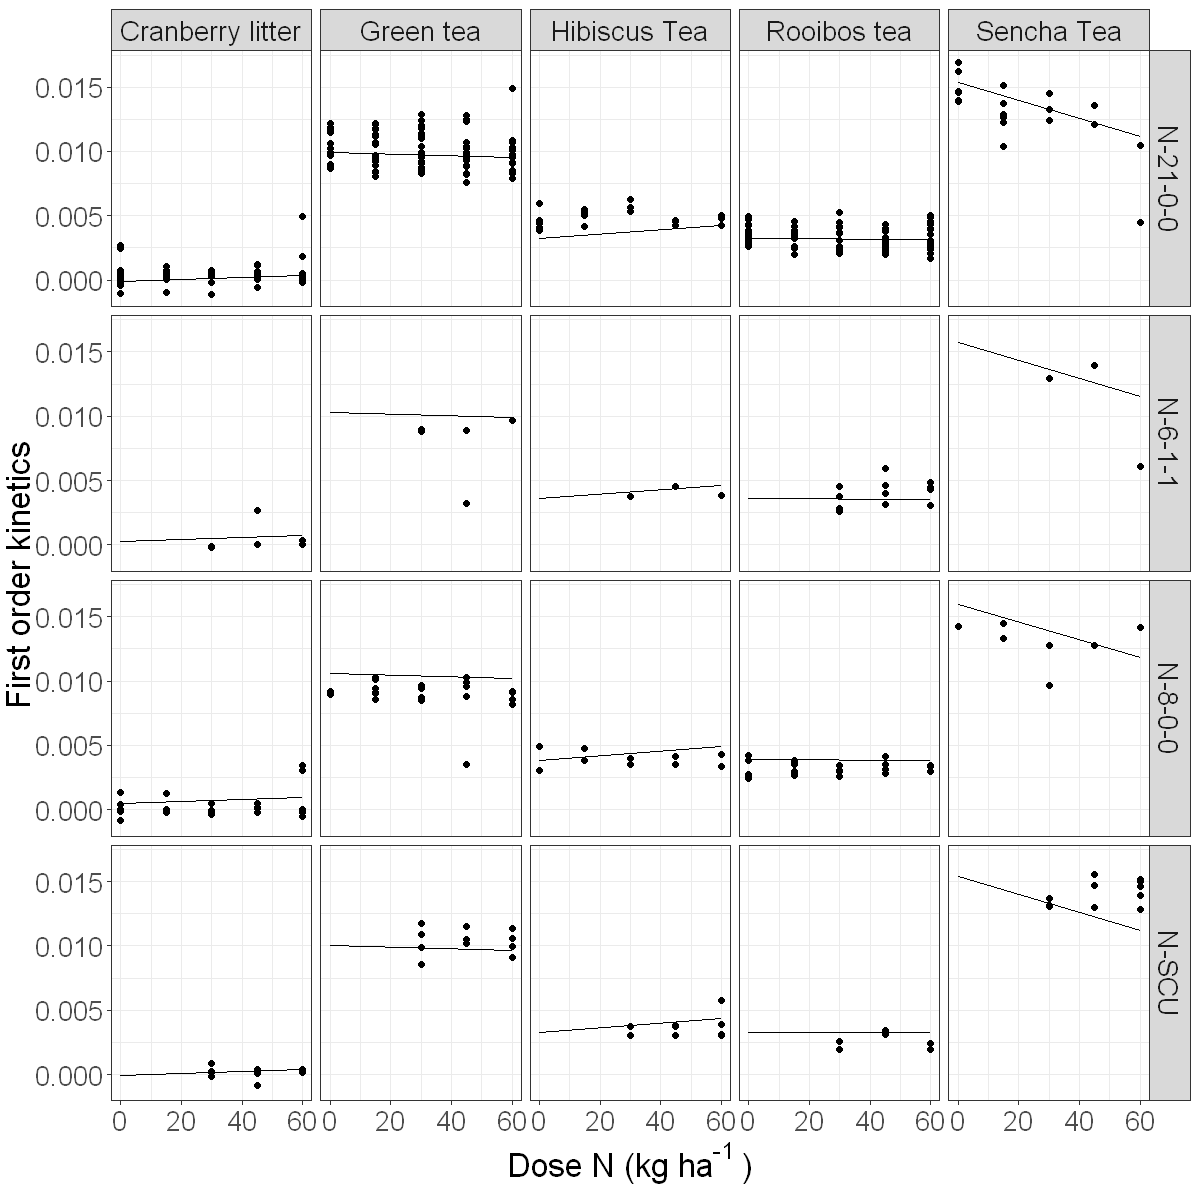

In [27]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(df, aes(x = `Nitrogen dose`, y = `k1`)) +
  facet_grid(`Nitrogen type` ~ `Tea type`) +
  geom_point() +
  geom_line(data = pred_grid) +
  labs(x = expression("Dose N (kg ha"^"-1"~")"), y = "First order kinetics") +
  theme_bw() +
  theme(text = element_text(size = 20)) + 
  ggsave("figures/k1-model-lines.png", width = 10, height = 6, dpi = 600)# nomme figure

## 9.2 **Question 2**: What affecting TBI parameters (k)?

Adding `M / M0` variable to data `df`.

In [28]:
df <- df %>%
  mutate(`M / M0` = `Remaining tea weight (g)` / `Initial tea weight (g)`)

I store hydrolysable fractions of green tea and rooibos.

In [29]:
Hf_g <- 0.805   # Hydrolysable fraction for Green tea
Hf_r <- 0.826   # Hydrolysable fraction for Rooibos tea

For comparaison purpose, [Keuskamp et al. (2013)](https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/2041-210X.12097) hydrolysable fractions were:

- Green tea `Hf_g = 0.842`  
- Rooibos tea `Hf_r = 0.552`

### 9.2.1 Computation of the labile fraction (a) and the stabilization factor (s) of green tea

Decomposition rate `k_tbi` is computed from Rooibos tea after 90 days of incubation. The *TBI* assumes that the decomposition of Green tea has stablilized while Rooibos tea is still decomposing. Stabilization factor `S` is computed from Green tea.

In [30]:
df <- df %>%
  mutate(a = ifelse(`Tea type` == "Green tea",
                    (`Initial tea weight (g)` - `Remaining tea weight (g)`) / `Initial tea weight (g)`,
                    NA),
         S = 1 - a / Hf_g)

Compute litter stability `Sg` (Green tea) and decomposition constant `k_tbi` (Rooibos) for each experimental unit.

In [31]:
df <- df %>%
  mutate(sdr = paste(df$Site, df$`Nitrogen dose`, df$Repetition))
sdr_u <- unique(df$sdr)

In [32]:
# Initialize k_tbi column
df$k_tbi <- NA

# For each rep, compute a and k_tbi
for (i in 1:length(sdr_u)) {
  # Green tea
  Sg_i <- mean(df$S[df$sdr == sdr_u[i] & df$`Tea type` == "Green tea"], na.rm = TRUE)
  
  # Rooibos
  df$a[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"] <- Hf_r * (1 - Sg_i)
  ar_i <- df$a[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"]
  M_M0i <- df$`M / M0`[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"]
  df$k_tbi[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"] <- log(ar_i / (M_M0i - (1-ar_i))) / 90
}

Data exploration for N dose type.

Warning message:
"Removed 388 rows containing missing values (geom_point)."

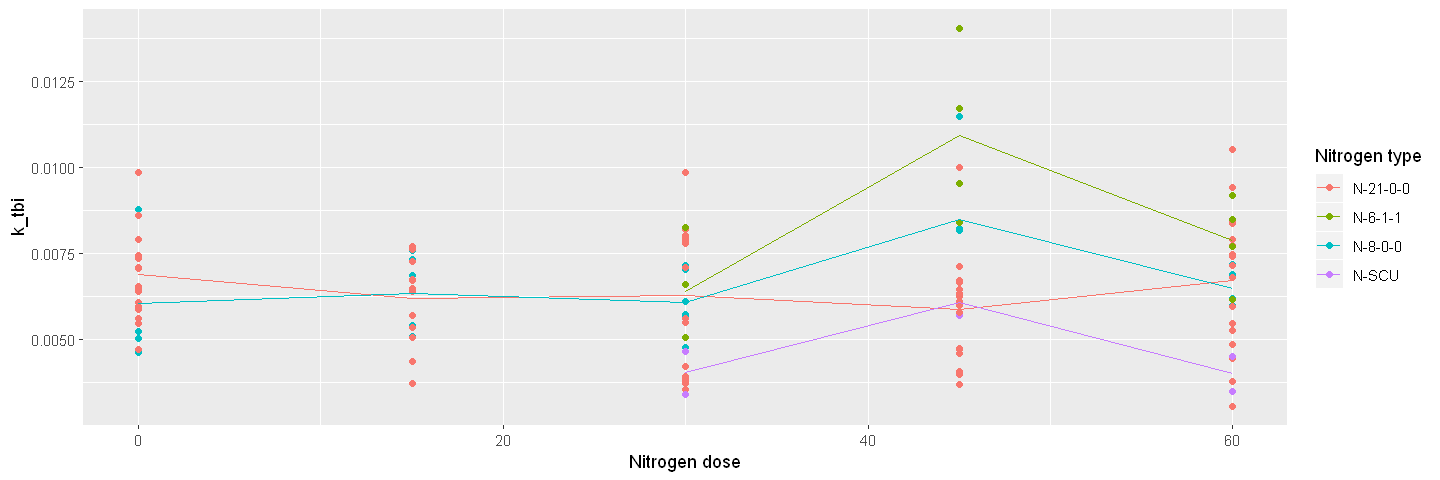

In [33]:
options(repr.plot.width=12, repr.plot.height=4)
ggplot(data = df,
       mapping = aes(x = `Nitrogen dose`, y = k_tbi)) +
  geom_point(aes(colour = `Nitrogen type`)) +
  geom_line(data = . %>%
    group_by(`Nitrogen dose`, `Nitrogen type`) %>%
    summarise(k_tbi = mean(k_tbi, na.rm = TRUE)),
           aes(colour = `Nitrogen type`))

### 9.3 What affecting TBI parameters (k)?

> **SÉP**. Je suis rendu ici.

As underline above, `k_tbi` is computed from Rooibos tea. Then, first we substract Rooibos data named `df_rooibos` 

In [34]:
df_rooibos <- df %>% 
  filter(`Tea type` == "Rooibos tea")

TBI_data <- df %>%
  select(k_tbi, `Tea type`, Farm, `Nitrogen dose`, Site,
         `Nitrogen type`) %>%
  rename(Ntype = `Nitrogen type`,
         Ndose = `Nitrogen dose`) %>%
  drop_na() %>%
  droplevels()

In [35]:
TBI_rooibos <- TBI_data %>%
  filter(`Tea type` == "Rooibos tea")

### 9.3.1 `k_tbi` mixed model

In [36]:
lme_TBI <- lme(fixed = k_tbi ~  Ndose + Ntype,
    random = ~ 1 | Farm/Site,
    data = TBI_rooibos)

In [37]:
pred_grid_tbi <- expand.grid(Ndose = c(0, 60),
                             Ntype = unique(df_mm$Ntype))
pred_grid_tbi <- pred_grid_tbi %>%
  mutate(k_tbi = predict(lme_TBI, newdata = pred_grid_tbi,
                              level = 0)) %>%
  rename(`Nitrogen dose` = Ndose,
         `Nitrogen type` = Ntype)

### 9.3.2 Effect of N dosage on k_tbi.

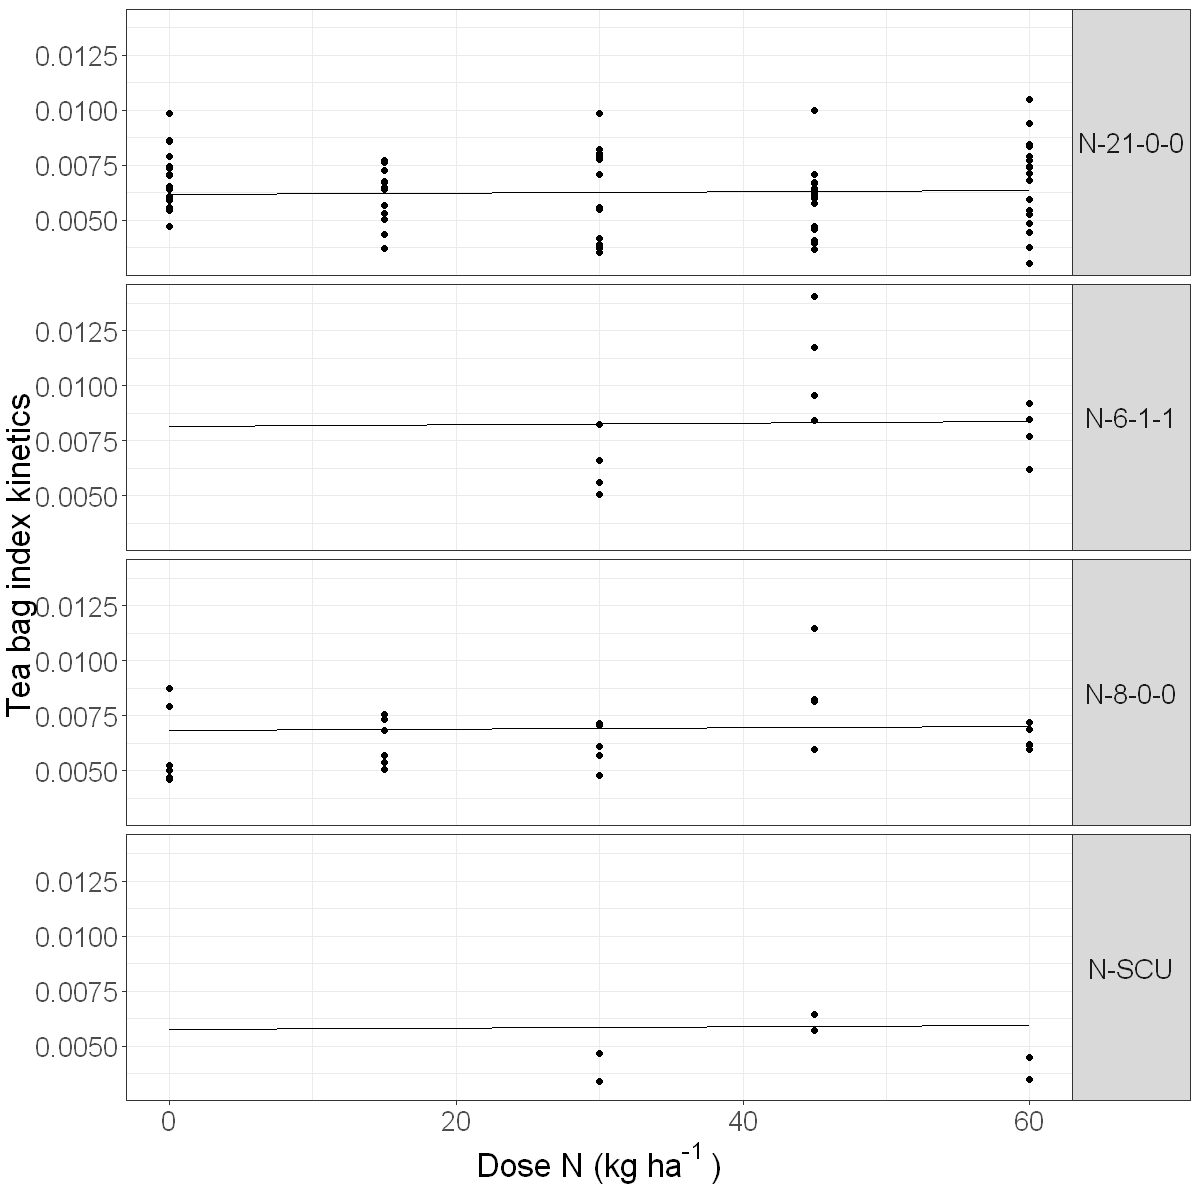

In [38]:
options(repr.plot.width=10, repr.plot.height=10)

TBI_rooibos %>% 
  rename(`Nitrogen dose` = Ndose,
         `Nitrogen type` = Ntype) %>%
  ggplot(aes(x = `Nitrogen dose`, y = k_tbi)) +
  facet_grid(`Nitrogen type` ~ .) +
  geom_point() +
  geom_line(data = pred_grid_tbi) +
  labs(x = expression("Dose N (kg ha"^"-1"~")"), y = "Tea bag index kinetics") +
  theme_bw() +
  theme(text = element_text(size = 20),
        strip.text.y = element_text(angle=0)) +
  ggsave("figures/tbi-model-lines.png", width = 10, height = 6, dpi = 600)

### 9.3.3 Mixed model graphic

In [39]:
ktbi_gg <- data.frame(intervals(lme_TBI, which = "fixed")$fixed)
ktbi_gg <- ktbi_gg %>%
  mutate(variable = rownames(ktbi_gg))
ktbi_gg <- ktbi_gg %>%
  mutate(pvalue = summary(lme_TBI)$tTable[, 5],
         is_significant = ifelse(pvalue <= 0.05, 'Significant at 0.05 level', 'Not significant at 0.05 level'))

Ajust names.

In [40]:
ktbi_gg$variable <- c("Intercept", "Dose N", "N 6-1-1", "N 8-0-0", "N SCU-39-0-0")

Add random effects to the table.

In [41]:
ktbi_re <- data.frame(matrix(ncol = ncol(ktbi_gg), nrow = 6))
names(ktbi_re) <- names(ktbi_gg)
ktbi_re$est. <- c(ranef(lme_TBI)$Farm[, 1], ranef(lme_TBI)$Site[, 1])
ktbi_re$variable <- c(rownames(ranef(lme_TBI)$Farm),
                    rownames(ranef(lme_TBI)$Site))

In [42]:
if (!("Belanger" %in% ktbi_gg$variable)) ktbi_gg <- bind_rows(ktbi_gg, ktbi_re) # with an if to make sure ranefs are stacked only once

Create a facet column to separate effects by effect category in the plot.

In [43]:
ktbi_gg$facet <- factor(c('Intercept',
                        "N dosage",
                        'N source', 'N source', 'N source',
                        "Random effect", "Random effect", "Random effect", "Random effect", "Random effect", "Random effect"))

In [44]:
ktbi_gg <- ktbi_gg %>%
  mutate(facet = factor(facet, levels = rev(c("Random effect", "N dosage", "N source", "Intercept"))))

Warning message:
"Removed 6 rows containing missing values (geom_segment)."Warning message:
"Removed 6 rows containing missing values (geom_segment)."

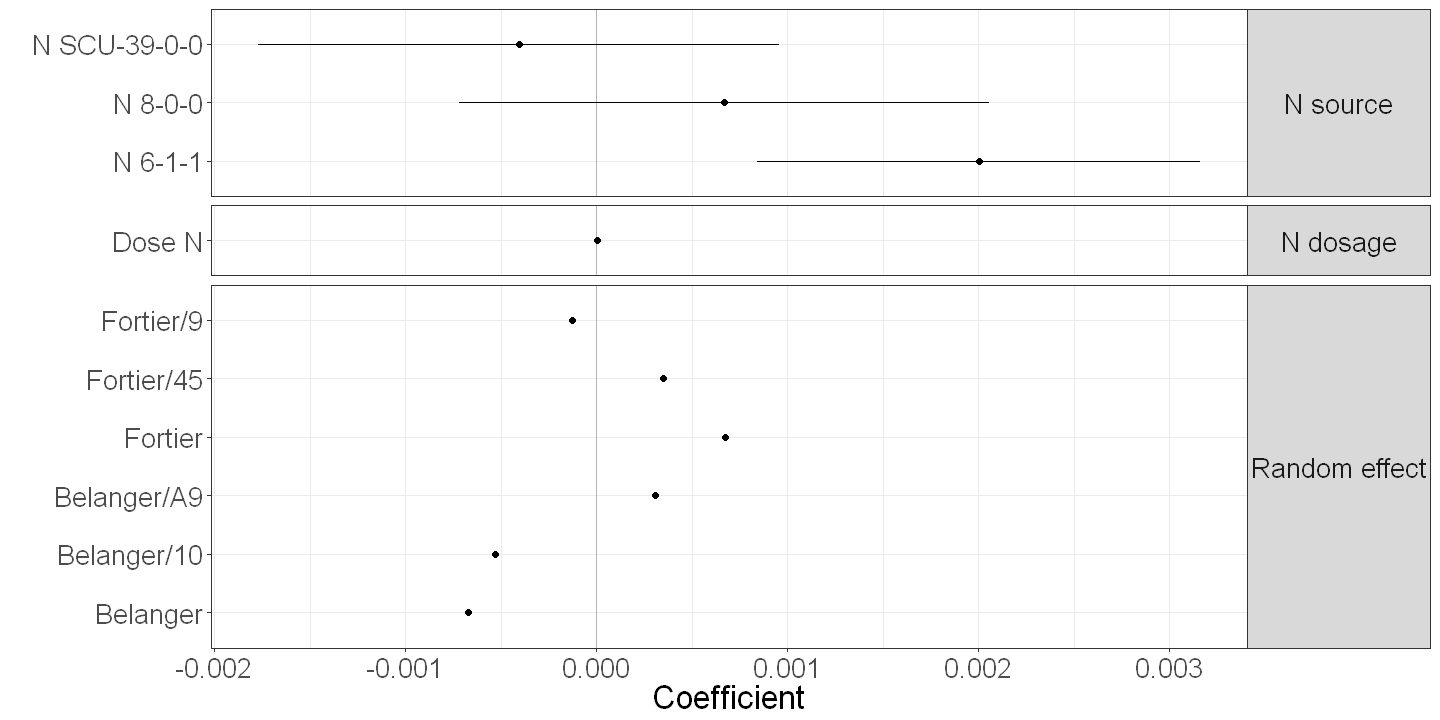

In [45]:
options(repr.plot.width = 12, repr.plot.height = 6)

ktbi_gg %>%
  filter(variable != "Intercept") %>%
  ggplot(aes(x = est., y = variable)) +
  facet_grid(facet ~ ., scales = 'free', space = 'free') +
  geom_vline(xintercept = 0, colour='grey70') +
  geom_point() +
  geom_segment(aes(x = lower, xend = upper, y = variable, yend = variable)) +
  xlab('Coefficient') +
  ylab('') +
  theme_bw() +
  theme(strip.text.y = element_text(angle=0),
        legend.title = element_blank(),
        legend.position = "bottom",
        text = element_text(size = 20)) +
  ggsave("figures/ktbi-lme-effects.png", width = 8, height = 5, dpi = 600)

## 10. Litters biochemical composition balance

### 10.1 Import data

In [46]:
data_fiber <- read_csv('data/data_fiber_initial.csv')

Parsed with column specification:
cols(
  `Biomass type` = col_character(),
  `SOL perc initial (%)` = col_double(),
  `HOLO perc initial (%)` = col_double(),
  `LIC perc initial (%)` = col_double()
)


### 10.2 Isometic log ratio (Ilr)

In [47]:
TeaCompositionSBP <- matrix(c(-1, 1,1,
                              0, 1, -1),
                           byrow = TRUE,
                           ncol = 3)
colnames(TeaCompositionSBP) <- c('Lignine', 'Soluble', 'Holocelulose')
TeaCompositionComp <- acomp(data_fiber %>%
                      select(`LIC perc initial (%)`, `SOL perc initial (%)`,  `HOLO perc initial (%)`))
TeaCompositionBal <- ilr(TeaCompositionComp, V = gsi.buildilrBase(t(TeaCompositionSBP)))
data_fiber$TeaComposition_L.HS <- TeaCompositionBal[, 1] # ilr1 [Lignin | Soluble.Holocelulose]
data_fiber$TeaComposition_S.H <- TeaCompositionBal[, 2] # ilr2 [Soluble | Holocelulose]

### Plot of classification of litters using balances among biochemical components

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


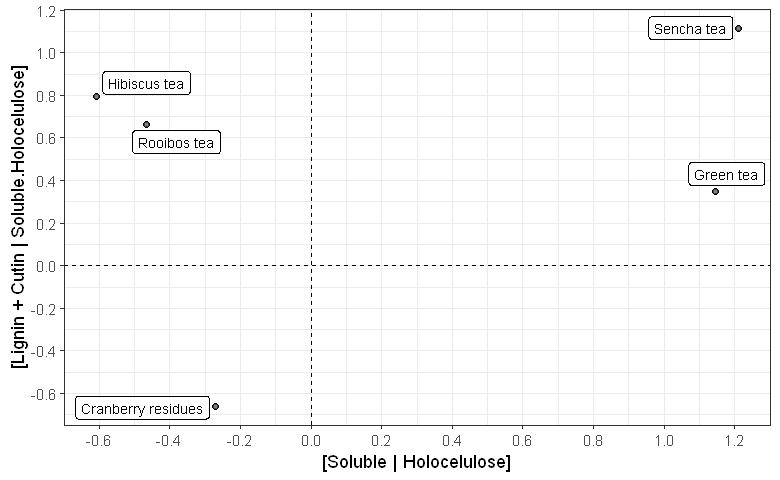

In [48]:
options(repr.plot.width = 6.5, repr.plot.height = 4)
ggplot(data_fiber, aes(x =  `TeaComposition_S.H`, y = `TeaComposition_L.HS`)) +
geom_point()+
geom_label_repel(aes(label = `Biomass type`), size = 3) +
labs(x = "[Soluble | Holocelulose]" , y = "[Lignin + Cutin | Soluble.Holocelulose]") +
theme(axis.title.x = element_text(size = 14), axis.title.y = element_text(size = 14)) +
xlim(-1.5, 1.5) +
scale_y_continuous(breaks=seq(-2,2,0.2)) + 
scale_x_continuous(breaks=seq(-2,2,0.2)) +
geom_hline(yintercept = 0, linetype = "dashed") +
geom_vline(xintercept = 0, linetype = "dashed") +
theme_bw() +
geom_point(size = 1, alpha = 0.5, pch = 21, fill = "white") 
ggsave("figures/Classification of litters using balances among biochemical components.png", width = 6.2, height = 4, dpi = 120)

## 11. **Question 3**: Where cranberry soils are placed among the axes of the *TBI*?

### 11.1 Import data

We adapted keuskamp's TBI by adding cranberry ecosystem

In [49]:
df_keuskamp <- read_csv("data/keuskamp_tbi_data.csv")# Import Keuskamp data

Parsed with column specification:
cols(
  Nombre = col_double(),
  Region = col_character(),
  Stabilisation_factor_S = col_double(),
  Decomposition_rate_K = col_double()
)


In [50]:
df_keuskamp <- df_keuskamp %>%
  mutate(is_cranberry = Region == "Cranberries")

### 11.2 Figure TBI_ Keuskamp

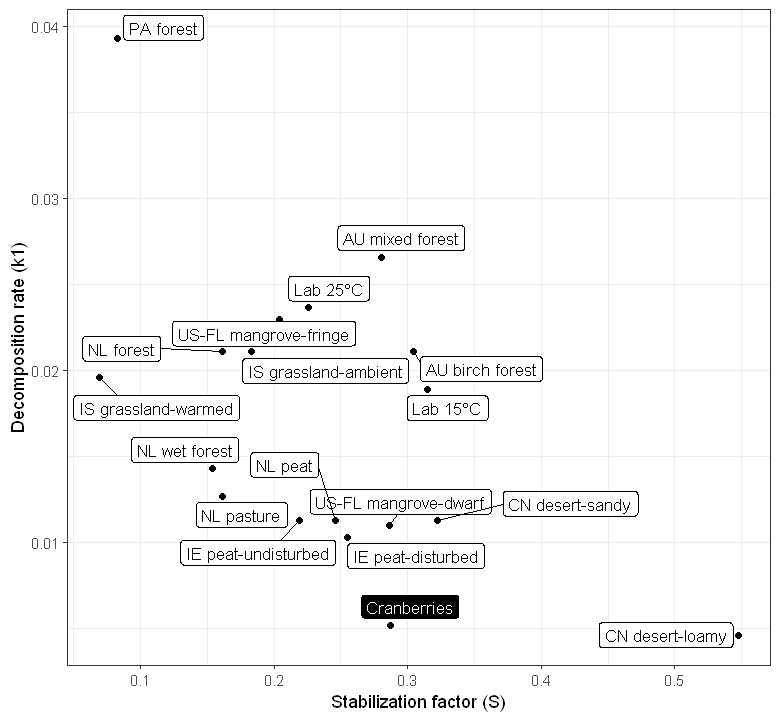

In [51]:
options(repr.plot.width = 6.5, repr.plot.height = 6)
ggplot(data = df_keuskamp, aes(x = Stabilisation_factor_S, y = Decomposition_rate_K)) +
  geom_point() +
  geom_label_repel(aes(label = Region, fill = is_cranberry, colour = is_cranberry),
                   size = 3.5) +
  scale_fill_manual(values = c("white", "black")) +
  scale_colour_manual(values = c("black", "white")) +
  theme_bw() +
  theme(legend.position = "none") +
  labs(x = "Stabilization factor (S)", y = "Decomposition rate (k1)") +
  ggsave("figures/TBI_keuskamp.png", width = 6, height = 6, dpi = 120)

### 12. **Question 4**:What is the fractal kinetics of litter matterials ?

Depending on the nature of decaying material and its immediate environment, the decomposition rate of plant residues can decrease gradually through time as follow: 
$$K(t) = k_1 t^{{-h}}$$

Where $k_1$ is reaction rate at time t = 1 and $h$ is a fractal coefficient (0 ≤ h ≤ 1) accounting for the decreasing decomposition rate through time

### 12.1 Import data

In [61]:
data_fractal <- read_csv2("data/data_fractal.csv")
#data_fractal

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.
Parsed with column specification:
cols(
  `Tea type` = col_character(),
  Prelevement = col_double(),
  `Final carbon (%)` = col_double(),
  `Final weight (g)` = col_double(),
  `Initial weight (g)` = col_double(),
  `Initial carbon (%)` = col_double()
)


### 12.2 Adding some variables
`Initial carbon (g)`, `Final carbon (g)` and `Log ratio` has been computed 

### 12.2.1 First order kinetics 

In [62]:
data_fractal <- data_fractal %>%
                    mutate(`First Order Kinetiks` = (- log(`Final weight (g)`/`Initial weight (g)`))/ (`Prelevement` * 21))
data_fractal  <- subset(data_fractal, `First Order Kinetiks` > 0)

In [68]:
data_fractal <- data_fractal %>%
mutate(`Initial carbon (g)` = `Initial weight (g)` * `Initial carbon (%)` / 100,
       `Final carbon (g)` = `Final weight (g)` * `Final carbon (%)` / 100,
       `Logk` = log(`First Order Kinetiks`),
       `Logt` = log(`Prelevement` * 21),
      `Log ratio` = - log(`Final carbon (g)`/`Initial carbon (g)`))%>%

rename(`Tea.type` = 'Tea type')

### 12.2.2 Mean an standard deviation of first order kinetics

In [70]:
data_mean_rooibos <- aggregate(`First Order Kinetiks` ~ `Tea.type`, data = data_fractal, FUN = mean)
data_mean_rooibos
data_sd_rooibos <- aggregate(`First Order Kinetiks` ~ `Tea.type`, data = data_fractal, FUN = sd)
data_sd_rooibos

Tea.type,First Order Kinetiks
Cranberry litter,0.0008353905
Green tea,0.0114839423
Rooibos tea,0.0039776542


Tea.type,First Order Kinetiks
Cranberry litter,0.0009684872
Green tea,0.0055935476
Rooibos tea,0.0014494302


In [72]:
data_rooibos <- subset(data_fractal, `Tea.type` == "Rooibos tea")
data_median_rooibos <- aggregate(cbind(Logt, Logk) ~ Prelevement + Tea.type, data = data_rooibos, FUN = median)

lm_rooibos <- lm(Logk ~ Logt, data_median_rooibos)

 coef(lm_rooibos)[1]
coef(lm_rooibos)[2]
summary(lm_rooibos)$r.squared

(Intercept) 
  -4.033306

Logt 
-0.3654122

[1] 0.9390858

In [73]:
data_rooibos <- subset(data_fractal, `Tea.type` == "Green tea")
data_median_rooibos <- aggregate(cbind(Logt, Logk) ~ Prelevement + Tea.type, data = data_rooibos, FUN = median)

lm_rooibos <- lm(Logk ~ Logt, data_median_rooibos)

 coef(lm_rooibos)[1]
coef(lm_rooibos)[2]
summary(lm_rooibos)$r.squared

(Intercept) 
  -1.619951

Logt 
-0.6985075

[1] 0.9943128

In [74]:
data_rooibos <- subset(data_fractal, `Tea.type` == "Cranberry litter")
data_median_rooibos <- aggregate(cbind(Logt, Logk) ~ Prelevement + Tea.type, data = data_rooibos, FUN = median)

lm_rooibos <- lm(Logk ~ Logt, data_median_rooibos)

 coef(lm_rooibos)[1]
coef(lm_rooibos)[2]
summary(lm_rooibos)$r.squared

(Intercept) 
  -7.209749

Logt 
-0.0207501

[1] 0.0004111749

### 12.3 Fractal kinetics computation

### Fractal kinetic ranged from 0 to 1. It's has been determined by trying value from `(0; 0.1; 0.2 ....1)` and choosing the one with maximum R square

### 12.3.1 Rooibos tea fractal kinetic 

`H_Rooibos = 0.2`

The coefficients obtained for each regression is stored in a table.

In [56]:
reg_coefs <- tibble(Tea.type = c("Rooibos tea", "Cranberry litter", "Green tea"),
                    h = c(0.2, 0, 0.7),
                    intercept = NA,
                    slope = NA,
                    rsq = NA)
reg_coefs

Tea.type,h,intercept,slope,rsq
Rooibos tea,0.2,NA,NA,NA
Cranberry litter,0.0,NA,NA,NA
Green tea,0.7,NA,NA,NA


In [57]:
H_Rooibos = 0.2
P_Rooibos = 1- H_Rooibos

data_rooibos <- subset(data_fractal, `Tea type` == "Rooibos tea")

data_rooibos <- data_rooibos %>%
  mutate(Time = (Prelevement * 21) ** P_Rooibos)%>%
  select(Prelevement, Time, `Log ratio`, `Tea type`)%>%
  rename(Log = `Log ratio`, `Tea.type` = 'Tea type')

data_rooibos <- rbind(data_rooibos, data.frame("Log" = 0, "Time" = 0, "Prelevement" = 0,
                                              "Tea.type" = "Rooibos tea")) 

data_median_rooibos <- aggregate(cbind(Time, Log) ~ Prelevement + Tea.type, data = data_rooibos, FUN = median)

lm_rooibos <- lm(Log ~ Time, data_median_rooibos)

reg_row <- 1
reg_coefs$intercept[reg_row] <- coef(lm_rooibos)[1]
reg_coefs$slope[reg_row] <- coef(lm_rooibos)[2]
reg_coefs$rsq[reg_row] <- summary(lm_rooibos)$r.squared

In [58]:
reg_coefs

Tea.type,h,intercept,slope,rsq
Rooibos tea,0.2,-0.02102096,0.007341073,0.943643
Cranberry litter,0.0,NA,NA,NA
Green tea,0.7,NA,NA,NA


In [59]:
data_rooibos$Logk <- data_rooibos$

ERROR: Error in parse(text = x, srcfile = src): <text>:2:0: unexpected end of input
1: data_rooibos$Logk <- data_rooibos$
   ^


## 12.3.2 Cranberry residue fractal kinetic 

`H_Cranberry = 0`

In [ ]:
H_Cranberry = 0
P_Cranberry = 1- H_Cranberry

data_cranberry <- subset(data_fractal, `Tea type` == "Cranberry litter")

data_cranberry <- data_cranberry %>%
                mutate(Time = (Prelevement * 21) ** P_Cranberry)%>%
                select(Prelevement, Time, `Log ratio`, `Tea type`)%>%
                rename(Log = `Log ratio`, `Tea.type` = 'Tea type')

data_cranberry <- rbind(data_cranberry, data.frame("Log" = 0, "Time" = 0, "Prelevement" = 0,
                                                  "Tea.type" = "Cranberry litter")) 

data_median_cranberry <- aggregate(cbind(Time, Log) ~ Prelevement + Tea.type, data = data_cranberry, FUN = median)
#data_median_cranberry <- aggregate(cbind(Time, Log) ~ Prelevement + Tea.type, data = data_cranberry, FUN = mean)

lm_cranberry <- lm(Log ~ Time, data_median_cranberry)

reg_row <- 2
reg_coefs$intercept[reg_row] <- coef(lm_cranberry)[1]
reg_coefs$slope[reg_row] <- coef(lm_cranberry)[2]
reg_coefs$rsq[reg_row] <- summary(lm_cranberry)$r.squared

### 12.3.3 Green tea fractal kinetic 

`H_Green = 0.7`

In [ ]:
H_Green = 0.7
P_Green = 1- H_Green

data_green <- subset(data_fractal, `Tea type` == "Green tea")

data_green <- data_green %>%
                mutate(Time = (Prelevement * 21) ** P_Green)%>%
                select(Prelevement, Time, `Log ratio`, `Tea type`)%>%
                rename(Log = `Log ratio`, `Tea.type` = 'Tea type')

data_green <- rbind(data_green, data.frame("Prelevement" = 0,"Time" = 0, 
                                           "Log" = 0, "Tea.type" = "Green tea")) 

data_median_green <- aggregate(cbind(Time, Log) ~ Prelevement + Tea.type, data = data_green, FUN = median)

lm_green <- lm(Log ~ Time, data_median_green)

reg_row <- 3
reg_coefs$intercept[reg_row] <- coef(lm_green)[1]
reg_coefs$slope[reg_row] <- coef(lm_green)[2]
reg_coefs$rsq[reg_row] <- summary(lm_green)$r.squared

In [ ]:
reg_coefs

## 12.3.4 Estimation of the carbon decreasing rate of teas and cranberry residue

### Reaction rate $k_1$ at time t = 1
$k_1$ is the slope of the regresssion lines

In [ ]:
K1_rooibos <- 0.007 
K1_green <- 0.19
K1_cranberry <- 0.002

### Litter decomposition rate K depends on time
$$K(t) = k_1 t^{{-h}}$$

### Computing and renaming somes variables

In [ ]:
data_rate <- data.frame(Prelevement = 1:7)%>%
                            mutate(`Time (days)` = `Prelevement` * 21,
                                  `Rate cranberry` = K1_cranberry *  `Time (days)`**-H_Cranberry,
                                  `Rate rooibos` = K1_rooibos * `Time (days)`**-H_Rooibos,
                                  `Rate green` = K1_green * `Time (days)`**-H_Green) %>%
                            rename(`Cranberry litter` = `Rate cranberry`,
                                  `Rooibos tea` = `Rate rooibos`,
                                   `Green tea` = `Rate green`)

### Tranforming data_rate into long format data in order to generate the plot

In [ ]:
data_long <- gather(data = data_rate, key = `tea type`, value = Rate, c(`Cranberry litter`, `Rooibos tea`, `Green tea`),
                    factor_key=TRUE)
data_long <- data_long %>%
             rename(`Litter type`= `tea type`)

### Plot of litter decomposition rate over time under field conditions

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6)
ggplot(data_long, aes(x = `Time (days)`, y = `Rate`, group = `Litter type`, color = `Litter type`)) +
geom_line() +
geom_point(aes(shape = `Litter type`), size = 2)+
#geom_smooth(method = "lm", formula = y ~ poly(x, 6) , color = 'grey', se = FALSE) + 
labs(x = "Elapsed time (days)" , y = expression("Decomposition rate (d"^" -1"~")"))  +
theme(axis.title.x = element_text(size = 14), 
  axis.title.y = element_text(size = 14),
     legend.text=element_text(size=14)) +
scale_y_continuous(breaks = 0.002*0:1000,
                     expand = expand_scale(add = 0.002)) +
scale_x_continuous(breaks = 10*0:1000,
                     expand = expand_scale(add = 10)) +
theme_bw() +
ggsave("figures/K(t).png", width = 6, height = 4, dpi = 120)

## 13. **Question 4**: What is the fractal kinetics of litter biochemical composition ?

### 13.1 Biochemical composition data analysis 
Here, we load `data.csv`, `data_fiber_initial.csv` and `data_fiber.csv`available for the project in the `data` folder. The `data_2018.csv` contained incubation tea bag details and soil carateristics from the second essay in 2018; `data_fiber_initial.csv` contained only initial tea bag caracteristics and `data_fiber.csv` contained mostly tea bag biochemical details as soluble, holocellulose and lignin content. 
We wanted to use only data about `green tea`, `rooibos tea` and `cranberry residu`. In order to do that, we used `subset` function to get `data_subset`

In [ ]:
data <- read_csv('data/data_2018.csv', col_types = "??????????????f????????????????????")
data_fiber <- read_csv('data/data_fiber.csv')
data_fiber_initial <- read_csv('data/data_fiber_initial.csv')

data_subset <- subset(data,  (`Sampling period (3 weeks)`> 0 & (`Biomass type`== "Cranberry residu" | 
`Biomass type` == "Green tea"| `Biomass type` == "Rooibos tea")))

Join all 3 data with with `left_join` function. The obtained data is called `data_join_02`

In [ ]:
data_join <- data_subset %>%
  left_join(data_fiber, by = 'Iden fiber')

data_join_02 <- data_join %>%
  left_join(data_fiber_initial, by = 'Biomass type')

## 13.2 Some calculations 
### Initial and final content of carbon, soluble, holocellulose and lignin

In [ ]:
data_join_02 <- data_join_02 %>%
mutate(`Initial SOL content (g)` = `SOL perc initial (%)` * `Sample initial weight (g)` / 100,
       `Initial HOLO content (g)` = `HOLO perc initial (%)` * `Sample initial weight (g)` / 100,
       `Initial LIC content (g)` = `LIC perc initial (%)` * `Sample initial weight (g)` / 100,
       `Final SOL content (g)` = `SOL perc ILR (%)` * `Sample final weight (g)` / 100,
       `Final LIC content (g)` = `LIC perc ILR (%)` * `Sample final weight (g)` / 100,
       `Final HOLO content (g)` = `HOLO perc ILR (%)` * `Sample final weight (g)` / 100,
       `Initial Hydrolyzable content (g)` = `Initial SOL content (g)` +  `Initial HOLO content (g)`,
       `Final Hydrolyzable content (g)` = `Final SOL content (g)` + `Final HOLO content (g)`)

### 13.2.1 First order kinetic
Here,we compute decomposition rate of carbon, soluble, holocellulose and lignin using first order kinetic.

In [ ]:
kinetics_1st <- function(rw, iw, t) { # first order kinetic function
    -log(rw/iw)/t
}

In [ ]:
data_join_02 <- data_join_02 %>%
mutate(`rate SOL` = kinetics_1st(rw = `Final SOL content (g)`,
                      iw = `Initial SOL content (g)`,
                      t = `Sampling period (3 weeks)` * 21),
       `rate HOLO` = kinetics_1st(rw = `Final HOLO content (g)`,
                      iw = `Initial HOLO content (g)`,
                      t = `Sampling period (3 weeks)` * 21),
       `rate LIC` = kinetics_1st(rw = `Final LIC content (g)`,
                      iw = `Initial LIC content (g)`,
                      t = `Sampling period (3 weeks)` * 21),
       `rate Hydrolyzable` = kinetics_1st(rw = `Final Hydrolyzable content (g)`,
                      iw = `Initial Hydrolyzable content (g)`,
                      t = `Sampling period (3 weeks)` * 21),
      `Sampling period (days)` = `Sampling period (3 weeks)` * 21)

### 13.2.2 Selection all variables we interested in data_join_02. Our final data is called `data_filtre`

In [ ]:
na.action = na.exclude
data_filtre <- data_join_02 %>%
select(`Iden fiber`, `Biomass type`,  `Sampling period (days)`, `Site`, `Producer`,`Repetition`,
 `Initial SOL content (g)`, `Initial HOLO content (g)`, `Initial LIC content (g)`, `Final SOL content (g)`,`Final HOLO content (g)`, `Final LIC content (g)`,
       `Sample final weight (g)`, `Initial Hydrolyzable content (g)`, `Final Hydrolyzable content (g)`,
       `rate SOL`, `rate HOLO`, `rate LIC`, `rate Hydrolyzable`) %>% 
rename(Lignin = `rate LIC`, 
       Holocelulose = `rate HOLO`, 
       Soluble = `rate SOL`,
       Hydrolyzable = `rate Hydrolyzable`)

## 13.3 Missing values visualization

In [ ]:
library(VIM)
aggr(data_filtre, numbers = TRUE, prop = FALSE)
aggr(data_subset, numbers = TRUE, prop = FALSE)
aggr(data_fiber, numbers = TRUE, prop = FALSE)


In [ ]:
data_filtre_2 <- data_filtre[complete.cases(data_filtre), ]
nrow(data_filtre_2)
nrow(data_filtre)

## 13.4 Linear regressions of materials biochemical composition

### 13.4.1 Linear regression of remaining soluble content

In [ ]:
data_long <- gather(data = data_filtre, key = `Biochemical composition`, value = `Biochemical decomposition rate`, c(`Soluble`,
                                                                                                                    `Lignin`, `Holocelulose`, `Hydrolyzable`),
                    factor_key=TRUE)

In [ ]:
data_long <- subset(data_long, `Biochemical decomposition rate` > 0 & `Biomass type` == "Green tea" | `Biomass type` == "Rooibos tea")
data_long <- subset(data_long, `Biochemical composition` == "Lignin" | `Biochemical composition` == "Hydrolyzable")

In [ ]:
data_long <- data_long %>%
        mutate(`ln(k)` = log(`Biochemical decomposition rate`),
                `ln(t)` = log(`Sampling period (days)`))

In [ ]:
New.labs <- c("Non-Hydrolyzable", "Hydrolyzsable") # New facet names for variable `Biochemical composition`
names(New.labs) <- c("Lignin", "Hydrolyzable")

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6)
ggplot(data_long, aes(x =  `Sampling period (days)`, y = `Biochemical decomposition rate`)) +
#geom_point(aes(shape = `Biomass type`), size = 4)+
facet_grid( `Biochemical composition` ~ `Biomass type`, scales = "free",
           labeller = labeller(`Biochemical composition` = New.labs)) +
geom_smooth(method = "lm" , color = 'black', se = FALSE) + 
labs(x = "Time (days)" , y = "Biochemical decomposition rate") +
theme(axis.title.x = element_text(size = 18, face = "bold"), 
  axis.title.y = element_text(size = 18, face = "bold"),
     legend.text=element_text(size=14, face = "bold")) +
ylim(-0.05, 0.05) +
theme_bw() +
  geom_point(size = 1, alpha = 0.5, pch = 21, fill = "white") 
ggsave("figures/Linear regression of Biochemical decomposition rate.png", width = 8, height = 6, dpi = 80)

## 13.5 Biochemical fractal kinetics

In [ ]:
data_fractal <- data_long %>%
mutate(`Log ratio LIC` = - log(`Final LIC content (g)`/`Initial LIC content (g)`),
        `Log ratio HOLO` = - log(`Final HOLO content (g)`/`Initial HOLO content (g)`),
        `Log ratio SOL` = - log(`Final SOL content (g)`/`Initial SOL content (g)`),
        `Log ratio Hydrolyzable` = - log(`Final Hydrolyzable content (g)`/`Initial Hydrolyzable content (g)`))
     

### 13.5.1 Fractal of Rooibos tea Lignin content 

`H_LIC_Rooibos = 0`

In [ ]:
data_LIC_rooibos <- subset(data_fractal, `Biomass type` == "Rooibos tea"  & `Biochemical composition` == "Lignin" )

H_LIC_Rooibos = 0
P_LIC_Rooibos = 1- H_LIC_Rooibos

data_LIC_rooibos <- data_LIC_rooibos %>%
                mutate(Time = (`Sampling period (days)`) ** P_LIC_Rooibos)%>%
                select(`Sampling period (days)`, Time, `Log ratio LIC`, `Biomass type`)%>%
                rename(Log = `Log ratio LIC`, `Biomass.type` = `Biomass type`, `Prelevement`= `Sampling period (days)`)

data_LIC_rooibos <- rbind(data_LIC_rooibos, data.frame("Log" = 0, "Time" = 0, "Prelevement" = 0,
                                              "Biomass.type" = "Rooibos tea")) 

data_median_LIC_rooibos <- aggregate(cbind(Time, Log) ~ Prelevement + Biomass.type, data = data_LIC_rooibos, FUN = median)

Slope = coef(lm(`Log` ~ `Time`, data_median_LIC_rooibos))[2]
Intercept = coef(lm(`Log` ~ `Time`, data_median_LIC_rooibos))[1]
R.squared = summary(lm(Log ~ Time, data_median_LIC_rooibos))$r.squared
R.squared
Slope
Intercept

### 13.5.2 Fractal of Rooibos tea Hydrolyzable content 

`H_Hydro_Rooibos = 0.5`

In [ ]:
data_Hydro_rooibos <- subset(data_fractal, `Biomass type` == "Rooibos tea"  & `Biochemical composition` == "Hydrolyzable" )

H_Hydro_Rooibos = 0.5
P_Hydro_Rooibos = 1- H_Hydro_Rooibos

data_Hydro_rooibos <- data_Hydro_rooibos %>%
                mutate(Time = (`Sampling period (days)`) ** P_Hydro_Rooibos)%>%
                select(`Sampling period (days)`, Time, `Log ratio Hydrolyzable`, `Biomass type`)%>%
                rename(Log = `Log ratio Hydrolyzable`, `Biomass.type` = `Biomass type`, `Prelevement`= `Sampling period (days)`)

data_Hydro_rooibos <- rbind(data_Hydro_rooibos, data.frame("Log" = 0, "Time" = 0, "Prelevement" = 0,
                                              "Biomass.type" = "Rooibos tea")) 

data_median_Hydro_rooibos <- aggregate(cbind(Time, Log) ~ Prelevement + Biomass.type, data = data_Hydro_rooibos, FUN = median)

Slope = coef(lm(`Log` ~ `Time`, data_median_Hydro_rooibos))[2]
Intercept = coef(lm(`Log` ~ `Time`, data_median_Hydro_rooibos))[1]
R.squared = summary(lm(Log ~ Time, data_median_Hydro_rooibos))$r.squared
R.squared
Slope
Intercept

### 13.5.3 Fractal of Green tea Lignin content

`H_LIC_Green = 0.96`

In [ ]:
data_LIC_Green <- subset(data_fractal, `Biomass type` == "Green tea"  & `Biochemical composition` == "Lignin" )

H_LIC_Green = 0.96
P_LIC_Green = 1- H_LIC_Green

data_LIC_Green <- data_LIC_Green %>%
                mutate(Time = (`Sampling period (days)`) ** P_LIC_Green)%>%
                select(`Sampling period (days)`, Time, `Log ratio LIC`, `Biomass type`)%>%
                rename(Log = `Log ratio LIC`, `Biomass.type` = `Biomass type`, `Prelevement`= `Sampling period (days)`)

data_LIC_Green <- rbind(data_LIC_Green, data.frame("Log" = 0, "Time" = 0, "Prelevement" = 0,
                                              "Biomass.type" = "Green tea")) 

data_median_LIC_Green <- aggregate(cbind(Time, Log) ~ Prelevement + Biomass.type, data = data_LIC_Green, FUN = median)

Slope = coef(lm(`Log` ~ `Time`, data_median_LIC_Green))[2]
Intercept = coef(lm(`Log` ~ `Time`, data_median_LIC_Green))[1]
R.squared = summary(lm(Log ~ Time, data_median_LIC_Green))$r.squared
R.squared
Slope
Intercept

### 13.5.4 Fractal of Green tea Hydrolyzable content 

`H_Hydro_Green = 0.7`

In [ ]:
data_Hydro_Green <- subset(data_fractal, `Biomass type` == "Green tea"  & `Biochemical composition` == "Hydrolyzable" )

H_Hydro_Green = 0.7
P_Hydro_Green = 1- H_Hydro_Green

data_Hydro_Green <- data_Hydro_Green %>%
                mutate(Time = (`Sampling period (days)`) ** P_Hydro_Green)%>%
                select(`Sampling period (days)`, Time, `Log ratio Hydrolyzable`, `Biomass type`)%>%
                rename(Log = `Log ratio Hydrolyzable`, `Biomass.type` = `Biomass type`, `Prelevement`= `Sampling period (days)`)

data_Hydro_Green <- rbind(data_Hydro_Green, data.frame("Log" = 0, "Time" = 0, "Prelevement" = 0,
                                              "Biomass.type" = "Green tea")) 

data_median_Hydro_Green <- aggregate(cbind(Time, Log) ~ Prelevement + Biomass.type, data = data_Hydro_Green, FUN = median)

Slope = coef(lm(`Log` ~ `Time`, data_median_Hydro_Green))[2]
Intercept = coef(lm(`Log` ~ `Time`, data_median_Hydro_Green))[1]
R.squared = summary(lm(Log ~ Time, data_median_Hydro_Green))$r.squared
R.squared
Slope
Intercept